# <center>***BLACKHAWK NETWORK CASE STUDY- Gaurav J***</center>

<h2>Objective:</h2> 

* Predict the click counts for future planning



<h2>Directions from team:</h2> 

1. [Exploratory data analysis – any data cleaning and feature engineering. We want to see how your features evolve from your data understanding!](#Exploratory-data-analysis)

2. Train model(s) to predict the click counts.
3. Perform comparative analysis of the models and recommend the best model.
4. Visualise the prediction(s).


> ***Optional, but good to have***
1. Some model-fine tuning/optimisation – as much as you are able to do in the time!
2. Modular, functional/object-oriented code. Code that’s easy to understand, and extend.
3. Any interesting insights you found!


>***Expected Submission***
1. After you finish solving the problem, you will walk us through the solution. Please have a writeup/presentation that we can look at on a call. The write-up could be a Jupyter notebook, or a
presentation – whatever works for you.
2. Code: Please submit your code as zip file, and include a README that explains how to run it.
3. Write-up: This will give us an idea of your approach. Here are some ideas on what to include:
    * Any plots you used in the EDA.
    * Impact of model performance improving after any tuning.
    * Any insights you found.





<h2>Data information:</h2>

The Click Count dataset consists of the following files:
1. **ClickCounts.txt** - Contains information of clicks counts on daily basis for the past 3 years



## Assumptions:


#### 1. Why are we doing this? 
- Prepare better for website traffic during the holiday season (Nov- Dec - Jan). 
- Validation set will have holiday season to evaluate model performance. Validation set is from Nov-2018 to Jul'19

#### 2. How many days ahead in the future are we trying to predict?

- I'll go ahead with 9 months in future so that we can see predictions for another holiday season i.e. Nov'19-Dec'19-Jan'20 and evaluate if the predictions pick the December peak.
Next couple of months, i.e. Feb'20 and March'20 will help us assess the dip after peak season.


#### 3. Are these clicks for a specific product? 
- Going ahead with general website clicks



#### 4. Acceptance criteria? 
- Do better than baseline predictions. As there is a strong seasonality associated to this timeseries, a reasonable baseline could be last year's clickcounts, i.e. t vs t-1 year 




In [42]:
!pip install plotly  
!pip install pycaret[full]

In [97]:
import sys
import warnings

from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

init_notebook_mode(connected =True)

In [98]:
from datetime import datetime # datetime 
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import os

## Forecast quality metrics

Before we begin forecasting, let's understand the two evaluation metrics used in this analysis. Reason of choosing these metrics is to capture peaks during holiday season, i.e. Dec


- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 


- [Mean Absolute Percentage Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html): this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 



In [99]:
#CODE
def check_dups(df, col=['Date']):
    """Checks for duplicates at given col level
    :param df: Dataframe 
    :param col: column at which we need to check for duplicates
    :return: Row count before and after dropping duplicates
    """
    if df.shape[0] == df.drop_duplicates(col).shape[0]:
        print('No duplicates!')
    else:
        raise("Duplicates found! Please check")
    return df.shape[0], df.drop_duplicates(col).shape[0]


class cc_preprocessing(object):
    def __init__(self, cc_df_path):
        self.cc_df_path = cc_df_path
        return

    def load_data(self):
        if not os.path.exists(self.cc_df_path):
            raise("File not found! Please check")
        else:
            def dateparse(x): return datetime.strptime(
                x, '%d/%m/%y %H:%M')  # date format based on txt
            cc_df = pd.read_csv(self.cc_df_path,  sep="\t", parse_dates=[
                                'Date'], date_parser=dateparse)  # formating date and reading txt file
            # removing whitespaces from columns
            cc_df.columns = [x.strip() for x in list(cc_df.columns)]
            cc_df.rename({'Click Count': 'Click_Count'},
                         inplace=True, axis='columns')
            cc_df = cc_df.sort_values('Date')
        return cc_df

    @staticmethod
    def preprocess(cc_df):
      ## TODO - outliers removal
      ## TODO - Holiday features from prophet library
      ## TODO - mean endoded features at weekly & monthly level

        def weekday_flag(weekno):
            if weekno < 5:
                return 1
            else:  # 5 Sat, 6 Sun
                return 0

      ## TODO - Holiday features
      ## TODO - Sine Cosine features

        check_dups(cc_df)
        cc_df['Day'] = cc_df['Date'].dt.strftime('%A')
        cc_df['Week'] = cc_df['Date'].dt.week  # extracts week from date
        # ClickCounts['Weekday'] = cc_df['Date'].apply(lambda x: x.weekday()) #extracts Day of week from date
        cc_df['Weekday_flg'] = cc_df['Date'].apply(lambda x: x.weekday()).apply(
            weekday_flag)  # extracts weekend flag from date
        cc_df['Month_Desc'] = cc_df['Date'].dt.month.map(
            str) + "-" + cc_df['Date'].dt.strftime('%b').map(str)
        cc_df['Year'] = cc_df['Date'].dt.year  # extracts year from date

        for i in range(360, 371):
            # print('Shifting:', i)
            cc_df['lag_'+str(i)] = cc_df['Click_Count'].shift(i)

        return cc_df


def train_test_msplit(df, date='2018-11-01'):
    """Checks for duplicates at given col level
    :param df: Dataframe 
    :param date: Date for splitting dataset in train and test set. Default set to '2018-11-01' 
    :return: train, test dataset
    """
    train = df[df['Date'] < f'{date}']
    test = df[df['Date'] >= f'{date}']
    return train, test


def plot_ts(df: pd.DataFrame, pred: str = None, model: str = None):
    """Plot time series dataset
    :param df: Dataframe 
    :param pred: Predictions column, if exists
    :param model: Model name used for predictions, if exists
    """

    import plotly.graph_objs as go
    ## plot of this year vs last year. Taken as a basline
    ## TODO -center plots title
    ## TODO -aggregated level plots at month, year with and without sequence,

    fig = go.Figure()
    # Creating trace1

    fig.add_trace(go.Scatter(
        x=df['Date'],
        y=df['Click_Count'],
        mode="lines",
        name="Actuals",
        opacity=.5,
        marker=dict(color='rgba(80, 26, 80, 0.8)'),
        text=df['Click_Count']))

    plot_desc = 'Click Counts over time'

    if pred:
        # Creating trace2
        fig.add_trace(go.Scatter(
            x=df['Date'],
            y=df[pred],
            opacity=.3,
            mode="lines",
            name=pred,
            marker=dict(color='rgba(16, 50, 6, 0.8)'),
            text=df[pred]))

        Metric = mean_absolute_percentage_error(df['Click_Count'], df[pred])
        plot_desc = f'Click Counts this Actual vs {pred}  || MAPE :{Metric} %'

    if model:
        plot_desc = f'{model} : {plot_desc} '
        layout = dict(title=plot_desc, title_x=0.5,
                      xaxis=dict(title='Time', ticklen=5, zeroline=False),
                      yaxis=dict(title='Click Count',
                                 ticklen=5, zeroline=False)
                      )

    fig.update_layout(layout)
    fig.show()


# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# SMAPE Metric


def wsmape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) /
                                    (np.abs(actual) + np.abs(forecast))*100)
    return np.round(np.mean(result), 2)


def weekday_flag(weekno):
    if weekno < 5:
        return 1
    else:  # 5 Sat, 6 Sun
        return 0


## Exploratory-data-analysis

Exploratory data analysis (EDA) – any data cleaning and feature engineering. We want to see how your features evolve from your data understanding!

### Data cleaning
1. Reading original txt file
2. Setting the date in standard format; removing whitespaces from columns; replacing spaces from column name with '_'

In [100]:
case_study=cc_preprocessing('./ClickCounts.txt')
data=case_study.load_data()
data.head()

,Date,Click_Count
0,2016-01-01,2093576
1,2016-01-02,2397260
2,2016-01-03,2173039
3,2016-01-04,2051240
4,2016-01-05,1954117


### Feature engineering
1. Extracted Day from dates, i.e. Monday, Tuesday, Wednesday etc. This will be used as a categorical feature in our models and as activity of users change with days in a week.
2. Extracted Week number from dates, i.e. Week 1, 2 ,3 of the year. As certain weeks in an year have higher activity than others.
3. Extracted Weekday_flg from dates, i.e. Monday, Tuesday have 1; Sat, Sun have 0. This will be used as a categorical feature in our models and as activity of users change on weekends.
4. Extracted Months number from Months, i.e. 1-Jan, 2-Feb. As certain months in an year have higher activity than others, such as Decemeber
5. Extracted Year from dates,  as click count activity is changing year over year. This will help models to differentiate the year. 
6. Created lag_x from historical data, i.e. lag_360, lag_361. This will help model associate the previous years click counts with this years activity. This will also capture, seasonality and holiday effects to a good extend.


In [101]:
ClickCounts=cc_preprocessing.preprocess(data)
ClickCounts.head()

No duplicates!


,Date,Click_Count,Day,Week,Weekday_flg,Month_Desc,Year,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370
0,2016-01-01,2093576,Friday,53,1,1-Jan,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,2397260,Saturday,53,0,1-Jan,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,2173039,Sunday,53,0,1-Jan,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,2051240,Monday,1,1,1-Jan,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,1954117,Tuesday,1,1,1-Jan,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PLOTS

Let's plot click counts with time and see if there is any seasonlity and trends

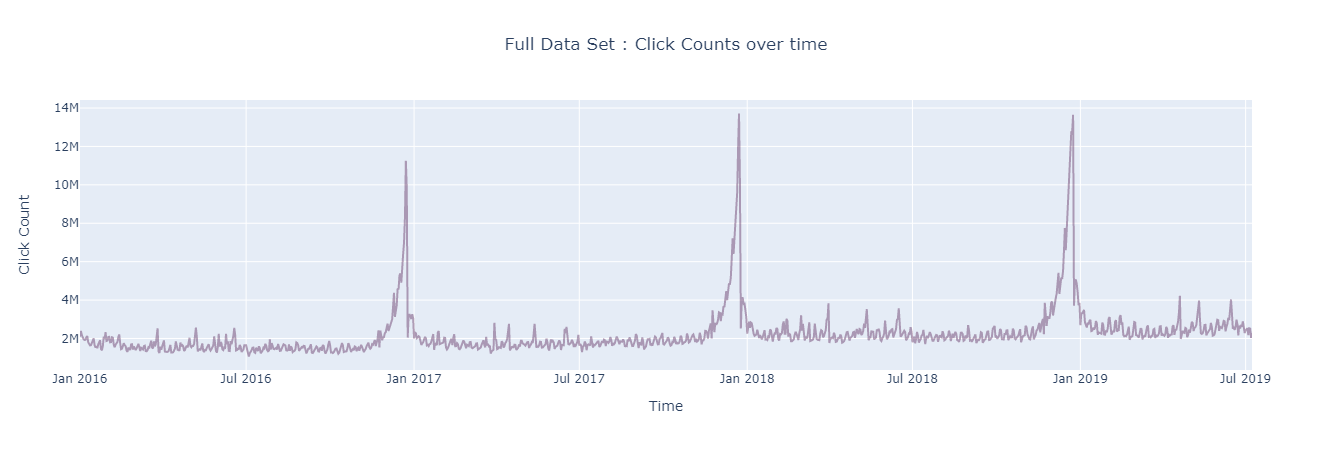

In [102]:
plot_ts(df=ClickCounts, model='Full Data Set')

There are peaks in December for all the three years of data, we see a strong seasonality pattern here, likely because of the holiday effect.
The click counts are also increasing slighlty year over year

## Baseline

A naive hypothesis here could be: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), but as we are trying to predict a much longer window into the future, i.e. 9 months, we wont have $y_{t-1}$ available. So, we will instead take the last years value to predict future, take it as a baseline and check if any modeling technique can beat it.

$\hat{y}_{t} = y_{t-365}$



The reason of limiting the forecast to next 9 months (March 2020) is to avoid forecast during covid pandemic timeperiod. As historically we havent seen any such event, it would not be wise to expect model trained on historically trends to pick the variations.

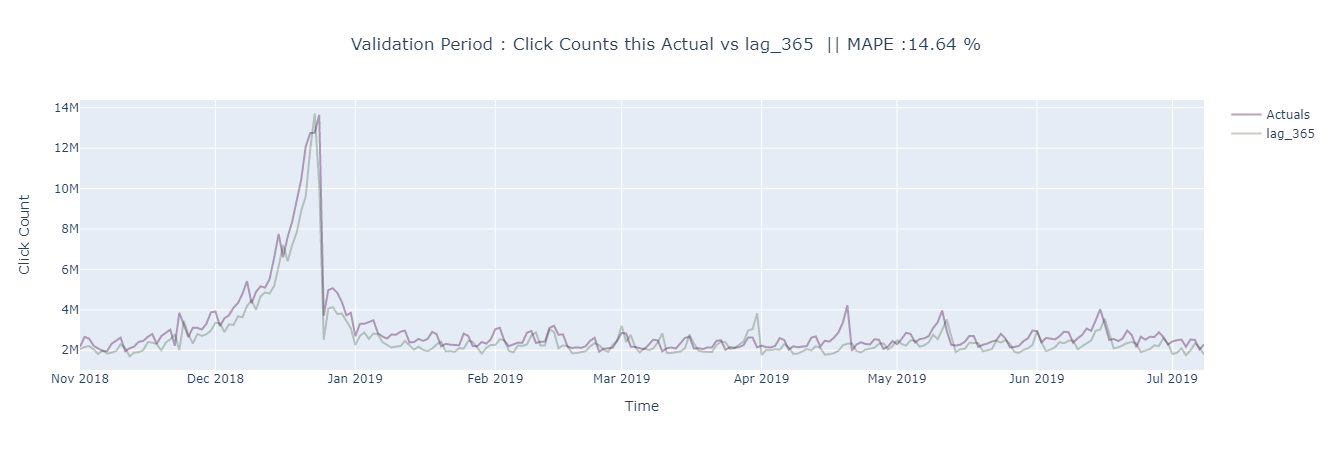

In [103]:
# Train Test split
train, test = train_test_msplit(ClickCounts)
plot_ts(df=test, pred='lag_365', model="Validation Period")

From the above plot we see that last year click counts are actually a good estimate for validation period's click count and MAPE value is 14.64%. The the next steps we will see if a modeling technique can beat this baseline

## EDA on Train Data

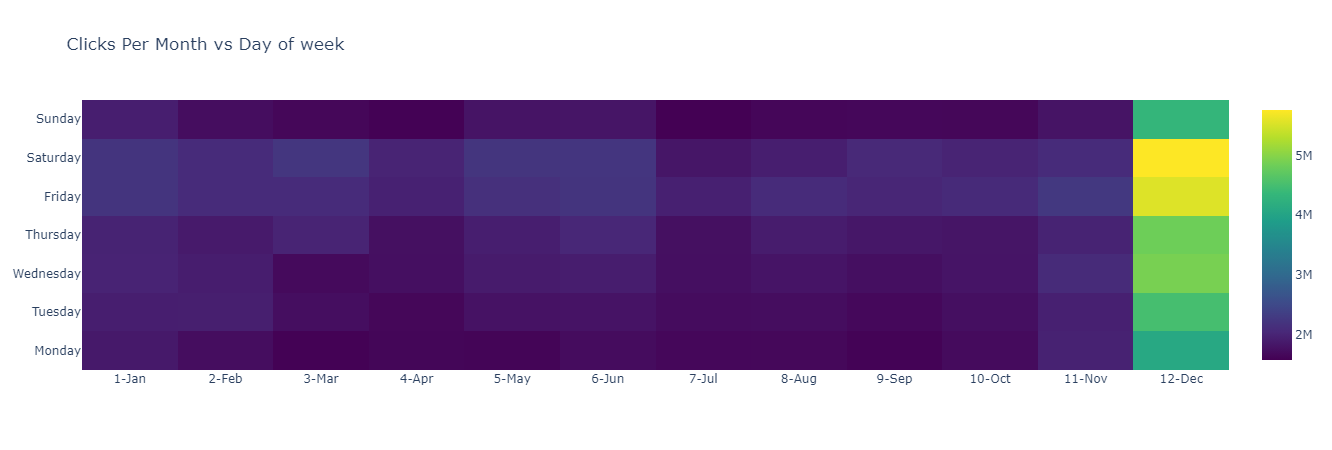

In [104]:
# EDA
train_group = train.groupby(["Month_Desc", "Day"])['Click_Count'].mean().reset_index()
xorder=['1-Jan','2-Feb','3-Mar','4-Apr','5-May','6-Jun','7-Jul','8-Aug','9-Sep','10-Oct','11-Nov','12-Dec']
yorder=['Monday','Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']

import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
        z=train_group.Click_Count,
        x=train_group.Month_Desc,
        y=train_group.Day,
        colorscale='Viridis'))

fig.update_layout(
    title='Clicks Per Month vs Day of week',
    xaxis_nticks=36, 
    xaxis={'categoryarray': xorder},
    yaxis={'categoryarray': yorder}
    )

fig.show()

This heatmap show us the average click counts by days across the months. In our data we can see there's higher activity on Friday & Saturday(Lighter blue color). 
December has the highest click counts possibily because its the peak holiday season. Month of Nov and Jan also has higher activity than the rest of months

# II. Train model(s) to predict the click counts.

I'll be using **Regression Machine learning modeling** approach  here rather than traditional time series forecasting methods such as **ARIMA or SARIMA**.
Reasoning here is that new machine learning techniques gives us more model tuning options. But these models cant associate trend and seasonality themselves, that is why feature engineering becomes critical here.
We have already created a few features i.e. **Lag variables, Calendar features**. We can create more features given enough time to improve the performance further.


I am using Pycaret for running multiple ML regression models for this feature engineered dataset and comparing all models to evaluate performance using time series k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds.
Primary evaluation metric used here is MAPE but Loss function to optimize is MAE so we can capture peaks better.

* Once we have predictions from the 4 models, I'll plot predictions over validation set(test) and assess their performance by both evalution metric MAPE and visually).
* If we only want to asssess the performance via a evaluation metric, Weighted SMAPE or Weight MAPE could be used. Weights would be proportional to Click counts for the day

In [105]:
num_features=[ 'lag_360', 'lag_361', 'lag_362', 'lag_363', 'lag_364',
       'lag_365', 'lag_366', 'lag_367', 'lag_368', 'lag_369', 'lag_370']
cat_features=['Day', 'Month_Desc','Weekday_flg','Year']

In [106]:

# from pycaret.utils import enable_colab
# enable_colab()
from pycaret.regression import *
# initialize setup
s = setup(data=train.drop('Date', axis=1), test_data=test.drop('Date', axis=1), target='Click_Count', fold_strategy='timeseries',
          numeric_features=num_features, categorical_features=cat_features,fold=3, transform_target=False, session_id=123);


,Description,Value
0,session_id,123
1,Target,Click_Count
2,Original Data,"(1035, 17)"
3,Missing Values,True
4,Numeric Features,12
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1035, 35)"


* Missing Values : When there are missing values in the original data, this will show as True. For this case study lag variables created have missing values

* Numeric Features : Number of features inferred as numeric. In this dataset after feature engineering there are 13 numeric variables 

* Categorical Features : Number of features inferred as categorical. In this dataset after feature engineering there are 3 numeric variables. Will perform one-hot encoding for these variables 

I will be building 4 models based on the following ML algorithms. 
* CATBOOST
* LIGHTGBM
* Elastic Net
* Bayesian Ridge

In [107]:
# best = compare_models(sort = 'MAE',n_select = 3, round =2, exclude = ['et','ada'])

In [108]:
# Model 1 CatBoost
catboost = create_model('catboost',round = 2)
tuned_catboost = tune_model(catboost, n_iter = 30, optimize = 'MAE')
test_predictions = predict_model(tuned_catboost, data=test)
test_predictions.rename({"Label":'Prediction'}, axis=1, inplace=True)
plot_ts(df=test_predictions, pred='Prediction', model='CatBoost: Validation Set')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,408575.8354,1294555863319.4214,1137785.5085,0.0645,0.3051,0.1224
1,489282.8045,928798352885.5586,963741.8497,0.6013,0.2284,0.1596
2,186046.7645,84134440572.6019,290059.3742,0.1228,0.1192,0.0766
Mean,361301.8015,769162885592.5273,797195.5775,0.2629,0.2176,0.1195
SD,128229.3510,506881062297.9893,365570.9190,0.2405,0.0763,0.0339


In [109]:
# Model 2 LightGBM
# Giving additional weights to samples in december, so model focuses more on learning patterns during holiday
def w_train_func(df):
    df['w_train'] = 1
    df.loc[df['Week'].isin([52, 53, 54]), 'w_train'] = 10
    return df.w_train


w_train = w_train_func(train)

# params = {"sample_weight" :w_train}

lightgbm = create_model('lightgbm', round=2)

tuned_lightgbm = tune_model(lightgbm, n_iter=30, optimize='MAE',
                            #                             custom_grid = params,
                        );

test_predictions = predict_model(tuned_lightgbm, data=test);
test_predictions.rename({"Label": 'Prediction'}, axis=1, inplace=True)
plot_ts(df=test_predictions, pred='Prediction',
        model='Light GBM: Validation Set')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,475834.6118,1560123646096.6384,1249049.0968,-0.1274,0.3790,0.1456
1,479767.1908,942658471966.8146,970906.0057,0.5953,0.2465,0.1599
2,250397.8681,127335797649.7072,356841.4181,-0.3276,0.1529,0.1040
Mean,401999.8902,876705971904.3867,858932.1735,0.0468,0.2595,0.1365
SD,107210.8394,586789317025.3755,372748.5657,0.3964,0.0928,0.0237


In [110]:
# Bayesian Ridge
br = create_model('br',round = 2)
tuned_br = tune_model(br, n_iter = 30, optimize = 'MAE')
test_predictions = predict_model(tuned_br, data=test)
test_predictions.rename({"Label":'Prediction'}, axis=1, inplace=True)
plot_ts(df=test_predictions, pred='Prediction', model='Bayesian Ridge : Validation Set')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,461074.6600,1442528677275.7556,1201053.1534,-0.0424,0.3479,0.1465
1,567050.6511,1565650605244.6562,1251259.6075,0.3279,0.2893,0.1746
2,190318.6027,66108017742.2837,257114.7949,0.3108,0.1112,0.0850
Mean,406147.9713,1024762433420.8986,903142.5186,0.1988,0.2495,0.1354
SD,158628.4231,679732039758.6953,457270.1877,0.1707,0.1007,0.0374


In [111]:
# Elastic Net
en = create_model('en',round = 2)
tuned_en = tune_model(en, n_iter = 30, optimize = 'MAE')
test_predictions = predict_model(tuned_en, data=test)
test_predictions.rename({"Label":'Prediction'}, axis=1, inplace=True)
plot_ts(df=test_predictions, pred='Prediction', model='Elastic Net : Validation Set')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,593666.2500,1661526999040.0000,1289002.3750,-0.2007,0.4235,0.2128
1,353869.4062,664892538880.0000,815409.4375,0.7146,0.1899,0.1157
2,260979.2500,114872508416.0000,338928.4688,-0.1976,0.1551,0.1164
Mean,402838.3021,813764015445.3334,814446.7604,0.1054,0.2562,0.1483
SD,140163.2966,640133874405.9210,387866.6454,0.4307,0.1192,0.0456


In [112]:
## Blending Elastic Net and Bayesian Ridge
blender = blend_models(estimator_list = [tuned_br, tuned_en])
test_predictions = predict_model(blender, data=test, verbose=False)
test_predictions.rename({"Label":'Prediction'}, axis=1, inplace=True)
plot_ts(df=test_predictions, pred='Prediction', model='Ensemble Model : Validation Set')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,512227.0000,1533581116870.1365,1238378.4223,-0.1082,0.3753,0.1704
1,442089.4364,997564548404.9918,998781.5319,0.5718,0.2120,0.1348
2,216380.6395,82786428858.5061,287726.3089,0.1369,0.1275,0.0965
Mean,390232.3586,871310698044.5449,841628.7544,0.2002,0.2382,0.1339
SD,126222.3822,598974864658.3982,403697.5822,0.2812,0.1029,0.0302


#III. Perform comparative analysis of the models and recommend the best model.

In [113]:
predict_model(tuned_en, round=3);
predict_model(tuned_br, round=3);
predict_model(tuned_lightgbm, round=3);
predict_model(tuned_lightgbm, round=3);

plot_ts(df=test_predictions, pred='Prediction', model=' Best Model: Elastic Net : Validation Set:')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,289201.688,245148844032.000,495125.094,0.914,0.121,0.095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,326127.581,299688834884.690,547438.430,0.895,0.133,0.103


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,475470.079,579141687839.786,761013.592,0.797,0.194,0.136


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,475470.079,579141687839.786,761013.592,0.797,0.194,0.136


***We have a winner! Elastic Net*** gives us smallest error on the test/validation set among all the models we've tried so far. 
It also picked up the december peak really well and beat state of the art boosting tree based models on our dataset.


Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use LIGHTGBM or CATBOOST. For example, we can forecast trend separately with a linear model and then add predictions from CATBOOST or LIGHTBM models to get a final forecast.

# IV. Visualise the prediction(s).

In [114]:
# Synthesizing data for the next 9 months
future_dates = pd.DataFrame({'Date': pd.date_range('2019-07-09','2020-03-31', freq='D')})
future_dates['Day'] = future_dates['Date'].dt.strftime('%A')
future_dates['Week'] = future_dates['Date'].dt.week #extracts week from date
# future_dates['Weekday'] = future_dates['Date'].apply(lambda x: x.weekday()) #extracts Day of week from date
future_dates['Weekday_flg'] = future_dates['Date'].apply(lambda x: x.weekday()).apply(weekday_flag) #extracts weekend flag from date
future_dates['Month_Desc'] =future_dates['Date'].dt.month.map(str) + "-" + future_dates['Date'].dt.strftime('%b').map(str)
future_dates['Year'] = future_dates['Date'].dt.year #extracts year from date

## get lag features for future data
future_dates['future_flg']=1
ClickCounts['future_flg']=0
full_dataframe=pd.concat([ClickCounts,future_dates]).sort_values('Date')
for i in range(360,371):
    full_dataframe['lag_'+str(i)] = full_dataframe['Click_Count'].shift(i)  


In [115]:
future_date=full_dataframe[full_dataframe.future_flg==1]
test_predictions = predict_model(tuned_en, data=future_date, verbose=False);
test_predictions.rename({"Label":'Future_Predictions'}, axis=1, inplace=True);
full_dataframe=pd.concat([ClickCounts,test_predictions]).sort_values('Date');
plot_ts(df=full_dataframe, pred='Future_Predictions', model=' Best Model: Elastic Net: Future Predictions')

Here I am plotting the future predictions (for next 9 months). We see the that model is able to predict the next peak again in Dec'2019 based on its learning from historical dataset. We can compare the results from models to actuals as this is a back dated dataset to evaluate the accuracy of the model.

# Writeup

I used ***Regression Machine learning approach*** to predict future click counts. 

* Elastic Net stand alone gave the best results. It is a relatively simpler modeling technique which has similar interpretability like linear regression. The elastic net method performs variable selection and regularization simultaneously.
Groupings and variables selection are the key roles of the elastic net technique. It can be trained within minutes and can achieve more or less comparable results to other more complex solution.

There is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, state of the art **Regression Machine learning approach** or fancy neural net techniques.


**Acceptance criteria**
* Our final model performs better than the baseline $\hat{y}_{t} = y_{t-365}$.
Although it took some tuning and creating relevant feature such as Lag variables, Calendar features.


**Additional Possible enhancements**
* Further performance improvements can be made by more feature engineering and better cross validation framework and ensembling methods.





----
## Summary of Analysis
### Data cleaning
1. Reading original txt file
2. Setting the date in standard format; removing whitespaces from columns; replacing spaces from column name with '_'

### Feature engineering
1. Extracted Day from dates, i.e. Monday, Tuesday, Wednesday etc. This will be used as a categorical feature in our models and as activity of users change with days in a week.
2. Extracted Week number from dates, i.e. Week 1, 2 ,3 of the year. As certain weeks in an year have higher activity than others.
3. Extracted Weekday_flg from dates, i.e. Monday, Tuesday have 1; Sat, Sun have 0. This will be used as a categorical feature in our models and as activity of users change on weekends.
4. Extracted Months number from Months, i.e. 1-Jan, 2-Feb. As certain months in an year have higher activity than others, such as Decemeber
5. Extracted Year from dates,  as click count activity is changing year over year. This will help models to differentiate the year. 
6. Created lag_x from historical data, i.e. lag_360, lag_361. This will help model associate the previous years click counts with this years activity. This will also capture, seasonality and holiday effects to a good extend.


### Baseline
-  A naive hypothesis here could be: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), but as we are trying to predict a much longer window into the future, i.e. 9 months, we wont have $y_{t-1}$ available. So, we will instead take the last years value to predict future, take it as a baseline and check if any modeling technique can beat it.

- $\hat{y}_{t} = y_{t-365}$



- The reason of limiting the forecast to next 9 months (March 2020) is to avoid forecast during covid pandemic timeperiod. As historically we havent seen any such event, it would not be wise to expect model trained on historically trends to pick the variations.



### Train model(s) to predict the click counts.

- Using **Regression Machine learning modeling** approach  here rather than traditional time series forecasting methods such as **ARIMA or SARIMA**.
Reasoning here is that new machine learning techniques gives us more model tuning options. But these models cant associate trend and seasonality themselves, that is why feature engineering becomes critical here.
We have already created a few features i.e. **Lag variables, Calendar features**. We can create more features given enough time to improve the performance further.

- Used the following ML algorithms. 
* CATBOOST
* LIGHTGBM
* Elastic Net
* Bayesian Ridge



